In [4]:

import sys
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.linalg import expm
from ipywidgets import interact, widgets, FloatSlider
from IPython.display import display
import cmath
from Function import create_adjacency_matrices, Gaussian_initial_state,evolve_2d_graph, superposition_initial_state, localized_initial_state,coherent_state


This notebook is a simulation for unitary evolution of a quantum walk on different graph topologies. the user has the option to choose among different initial states and graphs, and based on these the probability distrubtion over time for the walker to be on a certain vertex is plotted. In comarison a stocastic walk has also been plotted to qualitatively compared the avolution dynamics of both Classical and Quantum case. 

An interactive widget can be run to visualize the walk on the graphs itself.  networkx library has been used to define and acquire graphs and characertertisc of these graphs. ipywdiges has been used to create the interactive part using the Widget.Play command. 

Custom functions have been imported from .py file inn the same directory to make things more readable and neat

In the following cell,  we initialize the parameters required for computing a quantum and a classical walk on different graph structures:

N(int type ) refers to the number of verticeor nodes. Basically the number of discrete points that a graph will me made of. 
graph_type is to initialize the graph that the user wants to initate. In this simulations they can be choosen among {'2D Grid','Cyclic Graph','Random'}
Similarly initial states can be chosen from { Localized, Gaussian, Superposition, Coherent state}. The syntax to call the function  for respective state is as follows: 
example: 

initial_state = localized_initial_state(N, 24) , where the localized_initial_state takes two arguments first is the number of vertices and second is the number of vertex where the walk has to be started. Here if N = 50 , in second argument 24 would refer  to the 25th vertex python initiatzes from 0 onwards

Gaussian_initial _state (a,b,c ) takes 3 parameters with first being the number of vertices, 2nd the center of the gaussian and 3rd arg is the width/variance of the gaussian.


 H, _ = create_adjacency_matrices(N, graph_type)

 acquires the corresponding adjacency matrix of the specific graph  type wit number of vertices. The adjacency matrix, A, of a graph with |G| = n vertices is an nxn matrix where the ijth entry, Aij represents the edge (i, j). If there is an edge between the vertex i and j, Aij = 1 otherwise zero. 


_,G= create_adjacency_matrices(N, graph_type) acquires the graph structure of the particular graph that will be drawn later


P = nx.to_numpy_array(G) 
P = P / np.sum(P, axis=1, keepdims=True) 

creates the transfer matrix for classical random walk that is essentially the probability of traveling from one vertex to another. 

time_range is basically to see the evlution of the walk for certain time.

In [5]:

N=49
graph_type = '2D Grid'
H, _ = create_adjacency_matrices(N, graph_type)
_,G= create_adjacency_matrices(N, graph_type)

# Initial state: walker starts at vertex 25
initial_state = localized_initial_state(N, 24)
P = nx.to_numpy_array(G)
P = P / np.sum(P, axis=1, keepdims=True)  # Ensure rows sum to 1

time_range = np.linspace(0, 30, 1000)


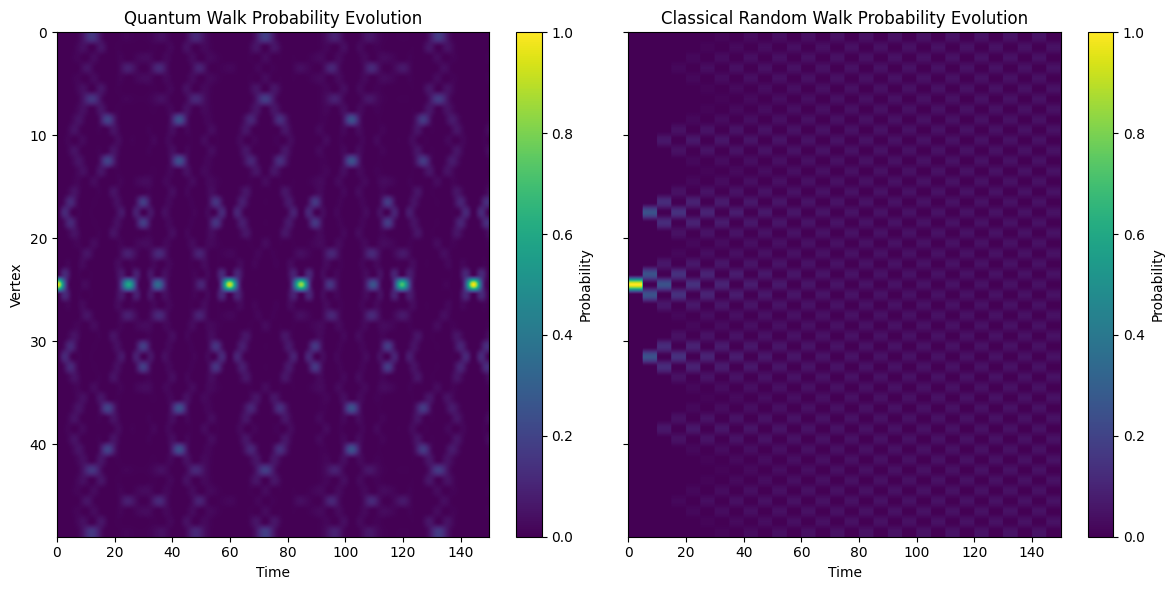

In [8]:


# Classical random walk function
def classical_random_walk_2d(P, initial_state, t):
    """
    Simulate a classical random walk on a graph and record probability distribution over time.

    Parameters:
    P (numpy.ndarray): Transition matrix for the classical random walk.
    initial_state (numpy.ndarray): Initial state vector.
    t (numpy.ndarray): Array of time steps.

    Returns:
    numpy.ndarray: Matrix of probabilities over time.
    """
    num_vertices = P.shape[0]
    data = np.zeros((num_vertices, len(t)))
    
    for i, ti in enumerate(t):
        state = initial_state.copy()
        for _ in range(int(ti)):  # Perform the random walk for 'ti' steps
            state = P @ state
        data[:, i] = np.abs (state.flatten())  # Store probabilities
    return data

# Compute probabilities over time for both walks
quantum_probabilities_over_time = evolve_2d_graph(H, initial_state, time_range)
classical_probabilities_over_time = classical_random_walk_2d(P, initial_state, time_range)

def plot_probability_evolution():
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Quantum walk heatmap
    im1 = axes[0].imshow(quantum_probabilities_over_time, aspect='auto', cmap='viridis', origin='lower',
                        extent=[time_range.min(), 150, N, 0])
    axes[0].set_title('Quantum Walk Probability Evolution')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Vertex')
    fig.colorbar(im1, ax=axes[0], label='Probability')
    
    # Classical walk heatmap
    im2 = axes[1].imshow(classical_probabilities_over_time, aspect='auto', cmap='viridis', origin='lower',
                        extent=[time_range.min(), 150, N, 0])
    axes[1].set_title('Classical Random Walk Probability Evolution')
    axes[1].set_xlabel('Time')
    fig.colorbar(im2, ax=axes[1], label='Probability')
    
    plt.tight_layout()
    plt.show()

plot_probability_evolution()

In [7]:
def update_plot(t, graph_type):
    """
    Update plot for quantum and classical random walks on various graph types.

    Parameters:
    t (float): Time step for the simulation.
    graph_type (str): Type of the graph ('Cyclic', '2D', 'Random').
    """
    # Ensure t is a scalar and not a list
    t = float(t)
    evolved_state = evolve_2d_graph(H, initial_state, [t])[:, 0]
    quantum_probabilities = np.abs(evolved_state)**2
        
    classical_state = classical_random_walk_2d(H, initial_state, [t])[:, 0]
    classical_probabilities = classical_state

    # Compute the probability distribution for quantum and classical walks
    if graph_type == 'Cyclic':
        
        # Cyclic graph layout
        pos = dict((n, (np.cos(2 * np.pi * n / N), np.sin(2 * np.pi * n / N))) for n in G.nodes())
    
    elif graph_type == '2D':
        # 2D grid graph layout
        pos = dict((n, n) for n in G.nodes())
    elif graph_type == 'Random':

        pos = nx.spring_layout(G)
    else: 
        raise ValueError("Unsupported graph type.")

    # Create a figure with two subplots
    plt.figure(figsize=(12, 6))

    # Quantum walk subplot
    plt.subplot(1, 2, 1)
    nx.draw(G, pos, node_color=quantum_probabilities, cmap=plt.cm.viridis,
            with_labels=True, node_size=600, font_color='white')
    plt.title(f'Quantum Walk at t = {t:.2f}')
    plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis), ax=plt.gca(), orientation='horizontal')

    # Classical walk subplot
    plt.subplot(1, 2, 2)
    nx.draw(G, pos, node_color=classical_probabilities, cmap=plt.cm.plasma,
            with_labels=True, node_size=600, font_color='white')
    plt.title(f'Classical Walk at t = {t:.2f}')
    plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.plasma), ax=plt.gca(), orientation='horizontal')

    plt.tight_layout()
    plt.show()

# Create a slider for time
#time_slider = widgets.FloatSlider(min=0, max=30, step=0.1, value=0, description='Time')
time_slider = widgets.Play(min=0, max=100, step=1, value=0, description='Time')
# Create a dropdown for selecting graph type
graph_type_dropdown = widgets.Dropdown(
    options=['Cyclic', '2D','Random'],
    value='Cyclic',
    description='Graph Type:',
)

# Use the interact function to link the slider and dropdown to the plot update
interact(update_plot, t=time_slider, graph_type=graph_type_dropdown)

interactive(children=(Play(value=0, description='Time'), Dropdown(description='Graph Type:', options=('Cyclic'…

<function __main__.update_plot(t, graph_type)>